In [25]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image as image_utils
from keras.applications.imagenet_utils import preprocess_input
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/My\ Drive/data/archive.zip

In [5]:
base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

58889256/58889256 [==============================] - 2s 0us/step


In [6]:
# Freeze base model
base_model.trainable = False

In [7]:
# Create inputs with correct shape
inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.GlobalAveragePooling2D()(x)

# Add final dense layer
outputs = keras.layers.Dense(6, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs, outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 3078      
                                                                 
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


In [9]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
#data augmentation
datagen = ImageDataGenerator(
        samplewise_center=True,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True) 


DataSet: https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification

In [11]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('dataset/train/', 
                                       target_size=(224,224), 
                                       color_mode='rgb', 
                                       class_mode="categorical")
# load and iterate validation dataset
valid_it = datagen.flow_from_directory('dataset/test/', 
                                      target_size=(224,224), 
                                      color_mode='rgb', 
                                      class_mode="categorical")

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [12]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [13]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [14]:
#trening
model.fit(train_it, 
          validation_data=valid_it, 
          steps_per_epoch=train_it.samples/train_it.batch_size,
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=8)

Epoch 1/8
340/340 [==============================] - 250s 703ms/step - loss: 0.6257 - accuracy: 0.8221 - val_loss: 0.1861 - val_accuracy: 0.9374
Epoch 2/8
340/340 [==============================] - 215s 631ms/step - loss: 0.1563 - accuracy: 0.9478 - val_loss: 0.1364 - val_accuracy: 0.9540
Epoch 3/8
340/340 [==============================] - 205s 602ms/step - loss: 0.1001 - accuracy: 0.9681 - val_loss: 0.1345 - val_accuracy: 0.9559
Epoch 4/8
340/340 [==============================] - 207s 608ms/step - loss: 0.0865 - accuracy: 0.9685 - val_loss: 0.1024 - val_accuracy: 0.9644
Epoch 5/8
340/340 [==============================] - 206s 604ms/step - loss: 0.0713 - accuracy: 0.9759 - val_loss: 0.1125 - val_accuracy: 0.9633
Epoch 6/8
340/340 [==============================] - 204s 599ms/step - loss: 0.0651 - accuracy: 0.9754 - val_loss: 0.0644 - val_accuracy: 0.9792
Epoch 7/8
340/340 [==============================] - 203s 596ms/step - loss: 0.0625 - accuracy: 0.9783 - val_loss: 0.0613 - val_ac

In [15]:
#fine tuning

# Unfreeze the base model
base_model.trainable = True

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),
              loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
model.fit(train_it, 
          validation_data=valid_it, 
          steps_per_epoch=train_it.samples/train_it.batch_size,
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=3)

Epoch 1/3
340/340 [==============================] - 245s 701ms/step - loss: 0.0603 - accuracy: 0.9800 - val_loss: 0.0238 - val_accuracy: 0.9922
Epoch 2/3
340/340 [==============================] - 235s 688ms/step - loss: 0.0215 - accuracy: 0.9934 - val_loss: 0.0103 - val_accuracy: 0.9956
Epoch 3/3
340/340 [==============================] - 236s 693ms/step - loss: 0.0115 - accuracy: 0.9970 - val_loss: 0.0036 - val_accuracy: 0.9993


In [17]:
model.evaluate(valid_it, steps=valid_it.samples/valid_it.batch_size) #loss and accuracy

84/84 [==============================] - 40s 477ms/step - loss: 0.0036 - accuracy: 0.9989


[0.0036389741580933332, 0.9988880753517151]

In [22]:
def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    image = tf.keras.utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

In [39]:
def classes(pred):
  br=np.argmax(pred)
  if br==0:
    klasa='fresh apple'
  elif br==1:
    klasa='fresh banana'
  elif br==2:
    klasa='fresh orange'
  elif br==3:
    klasa='rotten apple'
  elif br==4:
    klasa='rotten banana'
  elif br==5:
    klasa='rotten orange'

  return klasa

1/1 [==============================] - 0s 20ms/step
Klasa: fresh apple


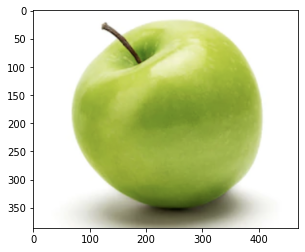

In [40]:
pred=make_predictions('dataset/test/freshapples/Screen Shot 2018-06-08 at 4.59.44 PM.png')
klasa=classes(pred)
print('Klasa:', klasa)

1/1 [==============================] - 0s 19ms/step
Klasa: rotten apple


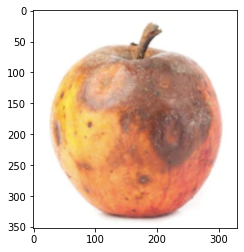

In [41]:
pred=make_predictions('dataset/test/rottenapples/Screen Shot 2018-06-07 at 2.15.34 PM.png')
klasa=classes(pred)
print('Klasa:', klasa)

1/1 [==============================] - 0s 16ms/step
Klasa: rotten orange


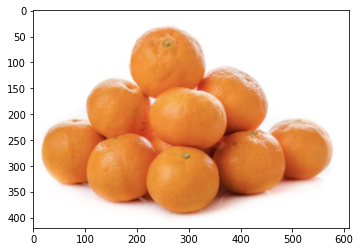

In [42]:
pred=make_predictions('dataset/test/freshoranges/Screen Shot 2018-06-12 at 11.53.43 PM.png')
klasa=classes(pred)
print('Klasa:', klasa)

1/1 [==============================] - 0s 24ms/step
Klasa: rotten orange


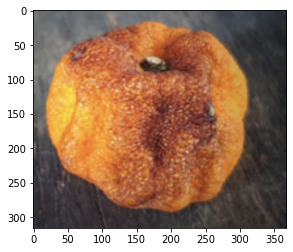

In [43]:
pred=make_predictions('dataset/test/rottenoranges/Screen Shot 2018-06-12 at 11.20.59 PM.png')
klasa=classes(pred)
print('Klasa:', klasa)

In [34]:
model.save('my_model')